In [1]:
%matplotlib inline


DCGAN Tutorial
==============

**Author**: `Nathan Inkawhich <https://github.com/inkawhich>`__




Introduction
------------

This tutorial will give an introduction to DCGANs through an example. We
will train a generative adversarial network (GAN) to generate new
celebrities after showing it pictures of many real celebrities. Most of
the code here is from the dcgan implementation in
`pytorch/examples <https://github.com/pytorch/examples>`__, and this
document will give a thorough explanation of the implementation and shed
light on how and why this model works. But don’t worry, no prior
knowledge of GANs is required, but it may require a first-timer to spend
some time reasoning about what is actually happening under the hood.
Also, for the sake of time it will help to have a GPU, or two. Lets
start from the beginning.

Generative Adversarial Networks
-------------------------------

What is a GAN?
~~~~~~~~~~~~~~

GANs are a framework for teaching a DL model to capture the training
data’s distribution so we can generate new data from that same
distribution. GANs were invented by Ian Goodfellow in 2014 and first
described in the paper `Generative Adversarial
Nets <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__.
They are made of two distinct models, a *generator* and a
*discriminator*. The job of the generator is to spawn ‘fake’ images that
look like the training images. The job of the discriminator is to look
at an image and output whether or not it is a real training image or a
fake image from the generator. During training, the generator is
constantly trying to outsmart the discriminator by generating better and
better fakes, while the discriminator is working to become a better
detective and correctly classify the real and fake images. The
equilibrium of this game is when the generator is generating perfect
fakes that look as if they came directly from the training data, and the
discriminator is left to always guess at 50% confidence that the
generator output is real or fake.

Now, lets define some notation to be used throughout tutorial starting
with the discriminator. Let $x$ be data representing an image.
$D(x)$ is the discriminator network which outputs the (scalar)
probability that $x$ came from training data rather than the
generator. Here, since we are dealing with images the input to
$D(x)$ is an image of CHW size 3x64x64. Intuitively, $D(x)$
should be HIGH when $x$ comes from training data and LOW when
$x$ comes from the generator. $D(x)$ can also be thought of
as a traditional binary classifier.

For the generator’s notation, let $z$ be a latent space vector
sampled from a standard normal distribution. $G(z)$ represents the
generator function which maps the latent vector $z$ to data-space.
The goal of $G$ is to estimate the distribution that the training
data comes from ($p_{data}$) so it can generate fake samples from
that estimated distribution ($p_g$).

So, $D(G(z))$ is the probability (scalar) that the output of the
generator $G$ is a real image. As described in `Goodfellow’s
paper <https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf>`__,
$D$ and $G$ play a minimax game in which $D$ tries to
maximize the probability it correctly classifies reals and fakes
($logD(x)$), and $G$ tries to minimize the probability that
$D$ will predict its outputs are fake ($log(1-D(G(x)))$).
From the paper, the GAN loss function is

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

In theory, the solution to this minimax game is where
$p_g = p_{data}$, and the discriminator guesses randomly if the
inputs are real or fake. However, the convergence theory of GANs is
still being actively researched and in reality models do not always
train to this point.

What is a DCGAN?
~~~~~~~~~~~~~~~~

A DCGAN is a direct extension of the GAN described above, except that it
explicitly uses convolutional and convolutional-transpose layers in the
discriminator and generator, respectively. It was first described by
Radford et. al. in the paper `Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial
Networks <https://arxiv.org/pdf/1511.06434.pdf>`__. The discriminator
is made up of strided
`convolution <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`__
layers, `batch
norm <https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d>`__
layers, and
`LeakyReLU <https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU>`__
activations. The input is a 3x64x64 input image and the output is a
scalar probability that the input is from the real data distribution.
The generator is comprised of
`convolutional-transpose <https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d>`__
layers, batch norm layers, and
`ReLU <https://pytorch.org/docs/stable/nn.html#relu>`__ activations. The
input is a latent vector, $z$, that is drawn from a standard
normal distribution and the output is a 3x64x64 RGB image. The strided
conv-transpose layers allow the latent vector to be transformed into a
volume with the same shape as an image. In the paper, the authors also
give some tips about how to setup the optimizers, how to calculate the
loss functions, and how to initialize the model weights, all of which
will be explained in the coming sections.




In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 777
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  777


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [3]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Block to downsample the original images directly

In [4]:
import os
import shutil
from downsample_images import downsample_dir
from settings import DEFAULT_GAN_DATA, DEFAULT_GAN_OUTPUT

manual_downsample = False

# Root directory for dataset
dataroot = DEFAULT_GAN_OUTPUT + os.sep + 'input_src'

# create copy of source data in the output folder
src = DEFAULT_GAN_DATA
raw_images = dataroot + os.sep + 'raw'
raw_images_DS = raw_images + '_DS'

if not os.path.exists(raw_images):
    shutil.copytree(src, raw_images)

if manual_downsample:
    # create neighbouring folder 'raw_DS' containing downsampled images
    downsample_dir(raw_images, img_size=(64,64), SHOW=False)
    shutil.rmtree(raw_images)
else:
    if os.path.exists(raw_images_DS):
        shutil.rmtree(raw_images_DS + '_DS')

Data
----

In this tutorial we will use the `Celeb-A Faces
dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`__ which can
be downloaded at the linked site, or in `Google
Drive <https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg>`__.
The dataset will download as a file named *img_align_celeba.zip*. Once
downloaded, create a directory named *celeba* and extract the zip file
into that directory. Then, set the *dataroot* input for this notebook to
the *celeba* directory you just created. The resulting directory
structure should be:

::

   /path/to/celeba
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...

This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder. Now, we can create the dataset, create the
dataloader, set the device to run on, and finally visualize some of the
training data.




<class 'list'> 2 <class 'torch.Tensor'> torch.Size([128, 3, 64, 64])


'\nfor idx in range(10):\n    imgg=real_batch[0][idx]\n    plt.figure(figsize=(8,8))\n    plt.imshow(imgg)\n    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:1], padding=2, normalize=True).cpu(),\n                        (1,2,0))\n              )\n    print(type(real_batch), len(real_batch), type(real_batch[0]), real_batch[0].shape)\nplt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),\n                        (1,2,0))\n          )\n'

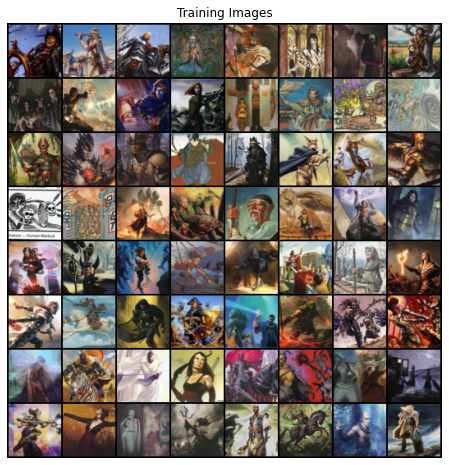

In [5]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
print(type(real_batch), len(real_batch), type(real_batch[0]), real_batch[0].shape)

"""
for idx in range(10):
    imgg=real_batch[0][idx]
    plt.figure(figsize=(8,8))
    plt.imshow(imgg)
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:1], padding=2, normalize=True).cpu(),
                        (1,2,0))
              )
    print(type(real_batch), len(real_batch), type(real_batch[0]), real_batch[0].shape)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),
                        (1,2,0))
          )
"""

Implementation
--------------

With our input parameters set and the dataset prepared, we can now get
into the implementation. We will start with the weigth initialization
strategy, then talk about the generator, discriminator, loss functions,
and training loop in detail.

Weight Initialization
~~~~~~~~~~~~~~~~~~~~~

From the DCGAN paper, the authors specify that all model weights shall
be randomly initialized from a Normal distribution with mean=0,
stdev=0.02. The ``weights_init`` function takes an initialized model as
input and reinitializes all convolutional, convolutional-transpose, and
batch normalization layers to meet this criteria. This function is
applied to the models immediately after initialization.




In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator
~~~~~~~~~

The generator, $G$, is designed to map the latent space vector
($z$) to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating a RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2d batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$. It is worth
noting the existence of the batch norm functions after the
conv-transpose layers, as this is a critical contribution of the DCGAN
paper. These layers help with the flow of gradients during training. An
image of the generator from the DCGAN paper is shown below.

.. figure:: /_static/img/dcgan_generator.png
   :alt: dcgan_generator

Notice, the how the inputs we set in the input section (*nz*, *ngf*, and
*nc*) influence the generator architecture in code. *nz* is the length
of the z input vector, *ngf* relates to the size of the feature maps
that are propagated through the generator, and *nc* is the number of
channels in the output image (set to 3 for RGB images). Below is the
code for the generator.




In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [8]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator
~~~~~~~~~~~~~

As mentioned, the discriminator, $D$, is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and LeakyReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and LeakyReLUs. The
DCGAN paper mentions it is a good practice to use strided convolution
rather than pooling to downsample because it lets the network learn its
own pooling function. Also batch norm and leaky relu functions promote
healthy gradient flow which is critical for the learning process of both
$G$ and $D$.




Discriminator Code



In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss Functions and Optimizers
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
(`BCELoss <https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss>`__)
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $log(D(x))$ and
$log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. As specified in the DCGAN paper, both are Adam
optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track
of the generator’s learning progression, we will generate a fixed batch
of latent vectors that are drawn from a Gaussian distribution
(i.e. fixed_noise) . In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.




In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training
~~~~~~~~

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in `ganhacks <https://github.com/soumith/ganhacks>`__.
Namely, we will “construct different mini-batches for real and fake”
images, and also adjust G’s objective function to maximize
$logD(G(z))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1 - Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$log(D(x)) + log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2 - Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$log(x)$ part of the BCELoss (rather than the $log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




In [12]:
print("Training Loop...")

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Training Loop...
Starting Training Loop...
[0/500][0/21]	Loss_D: 1.8907	Loss_G: 5.8419	D(x): 0.5768	D(G(z)): 0.6323 / 0.0047
[0/500][10/21]	Loss_D: 0.7728	Loss_G: 7.1420	D(x): 0.6558	D(G(z)): 0.0938 / 0.0014
[0/500][20/21]	Loss_D: 0.6573	Loss_G: 14.0933	D(x): 0.8356	D(G(z)): 0.3199 / 0.0000
[1/500][0/21]	Loss_D: 0.3709	Loss_G: 10.0807	D(x): 0.7791	D(G(z)): 0.0130 / 0.0001
[1/500][10/21]	Loss_D: 0.3942	Loss_G: 18.5744	D(x): 0.7403	D(G(z)): 0.0000 / 0.0000
[1/500][20/21]	Loss_D: 0.0418	Loss_G: 5.8111	D(x): 0.9692	D(G(z)): 0.0069 / 0.0051
[2/500][0/21]	Loss_D: 3.1949	Loss_G: 21.8360	D(x): 0.9732	D(G(z)): 0.9439 / 0.0000
[2/500][10/21]	Loss_D: 2.7821	Loss_G: 20.5416	D(x): 0.9837	D(G(z)): 0.9272 / 0.0000
[2/500][20/21]	Loss_D: 4.0236	Loss_G: 20.4865	D(x): 0.8893	D(G(z)): 0.9658 / 0.0000
[3/500][0/21]	Loss_D: 1.2740	Loss_G: 21.3250	D(x): 0.4838	D(G(z)): 0.0000 / 0.0000
[3/500][10/21]	Loss_D: 0.1602	Loss_G: 9.0788	D(x): 0.8989	D(G(z)): 0.0017 / 0.0002
[3/500][20/21]	Loss_D: 0.2366	Loss_G: 7.6

[32/500][20/21]	Loss_D: 0.5022	Loss_G: 6.2927	D(x): 0.8904	D(G(z)): 0.2978 / 0.0027
[33/500][0/21]	Loss_D: 0.3819	Loss_G: 4.5052	D(x): 0.7251	D(G(z)): 0.0221 / 0.0165
[33/500][10/21]	Loss_D: 0.4324	Loss_G: 5.2800	D(x): 0.8330	D(G(z)): 0.1935 / 0.0070
[33/500][20/21]	Loss_D: 0.6257	Loss_G: 3.4491	D(x): 0.5985	D(G(z)): 0.0336 / 0.0659
[34/500][0/21]	Loss_D: 0.9431	Loss_G: 7.9055	D(x): 0.8666	D(G(z)): 0.4694 / 0.0008
[34/500][10/21]	Loss_D: 0.4913	Loss_G: 3.8058	D(x): 0.7175	D(G(z)): 0.0606 / 0.0356
[34/500][20/21]	Loss_D: 0.6890	Loss_G: 4.4522	D(x): 0.7696	D(G(z)): 0.2805 / 0.0166
[35/500][0/21]	Loss_D: 0.6535	Loss_G: 1.5854	D(x): 0.6368	D(G(z)): 0.1023 / 0.2571
[35/500][10/21]	Loss_D: 0.5138	Loss_G: 3.1479	D(x): 0.7050	D(G(z)): 0.0941 / 0.0711
[35/500][20/21]	Loss_D: 0.4235	Loss_G: 3.6867	D(x): 0.8519	D(G(z)): 0.2022 / 0.0398
[36/500][0/21]	Loss_D: 0.4632	Loss_G: 3.0287	D(x): 0.7779	D(G(z)): 0.1497 / 0.0756
[36/500][10/21]	Loss_D: 0.7169	Loss_G: 6.5859	D(x): 0.8935	D(G(z)): 0.3974 / 0.0

[65/500][10/21]	Loss_D: 0.7565	Loss_G: 4.4268	D(x): 0.7512	D(G(z)): 0.3142 / 0.0201
[65/500][20/21]	Loss_D: 0.6761	Loss_G: 3.7718	D(x): 0.7672	D(G(z)): 0.2640 / 0.0371
[66/500][0/21]	Loss_D: 0.4592	Loss_G: 3.7104	D(x): 0.8004	D(G(z)): 0.1670 / 0.0406
[66/500][10/21]	Loss_D: 0.9280	Loss_G: 2.7187	D(x): 0.4857	D(G(z)): 0.0167 / 0.1073
[66/500][20/21]	Loss_D: 0.7095	Loss_G: 4.2694	D(x): 0.7183	D(G(z)): 0.2403 / 0.0266
[67/500][0/21]	Loss_D: 0.6027	Loss_G: 3.4723	D(x): 0.7281	D(G(z)): 0.1922 / 0.0512
[67/500][10/21]	Loss_D: 0.9840	Loss_G: 4.9060	D(x): 0.4648	D(G(z)): 0.0076 / 0.0207
[67/500][20/21]	Loss_D: 0.5022	Loss_G: 4.8437	D(x): 0.8201	D(G(z)): 0.2157 / 0.0115
[68/500][0/21]	Loss_D: 0.2836	Loss_G: 4.4837	D(x): 0.8479	D(G(z)): 0.0945 / 0.0143
[68/500][10/21]	Loss_D: 0.5606	Loss_G: 3.9030	D(x): 0.7309	D(G(z)): 0.1787 / 0.0295
[68/500][20/21]	Loss_D: 1.4808	Loss_G: 5.4384	D(x): 0.3030	D(G(z)): 0.0011 / 0.0123
[69/500][0/21]	Loss_D: 0.2060	Loss_G: 2.5667	D(x): 0.8653	D(G(z)): 0.0354 / 0.1

[98/500][0/21]	Loss_D: 0.4474	Loss_G: 3.6278	D(x): 0.8064	D(G(z)): 0.1647 / 0.0375
[98/500][10/21]	Loss_D: 0.5313	Loss_G: 3.9162	D(x): 0.8559	D(G(z)): 0.2707 / 0.0342
[98/500][20/21]	Loss_D: 0.7185	Loss_G: 5.3249	D(x): 0.8658	D(G(z)): 0.3879 / 0.0099
[99/500][0/21]	Loss_D: 0.5620	Loss_G: 3.2261	D(x): 0.6747	D(G(z)): 0.0893 / 0.0716
[99/500][10/21]	Loss_D: 0.8095	Loss_G: 3.2211	D(x): 0.6936	D(G(z)): 0.2883 / 0.0606
[99/500][20/21]	Loss_D: 0.6455	Loss_G: 3.0543	D(x): 0.6932	D(G(z)): 0.1367 / 0.0787
[100/500][0/21]	Loss_D: 0.6380	Loss_G: 4.6913	D(x): 0.8826	D(G(z)): 0.3500 / 0.0150
[100/500][10/21]	Loss_D: 0.8522	Loss_G: 3.2610	D(x): 0.6677	D(G(z)): 0.2856 / 0.0612
[100/500][20/21]	Loss_D: 0.7890	Loss_G: 5.3906	D(x): 0.8597	D(G(z)): 0.3968 / 0.0081
[101/500][0/21]	Loss_D: 0.7035	Loss_G: 2.5784	D(x): 0.5941	D(G(z)): 0.0684 / 0.1320
[101/500][10/21]	Loss_D: 0.6904	Loss_G: 3.1373	D(x): 0.7513	D(G(z)): 0.2629 / 0.0700
[101/500][20/21]	Loss_D: 0.6643	Loss_G: 2.6921	D(x): 0.7046	D(G(z)): 0.1905

[130/500][10/21]	Loss_D: 0.4108	Loss_G: 4.7515	D(x): 0.8626	D(G(z)): 0.1973 / 0.0149
[130/500][20/21]	Loss_D: 0.6863	Loss_G: 6.6265	D(x): 0.9411	D(G(z)): 0.3931 / 0.0026
[131/500][0/21]	Loss_D: 0.3667	Loss_G: 4.1575	D(x): 0.7484	D(G(z)): 0.0278 / 0.0283
[131/500][10/21]	Loss_D: 0.4311	Loss_G: 3.2731	D(x): 0.7787	D(G(z)): 0.1311 / 0.0554
[131/500][20/21]	Loss_D: 0.7969	Loss_G: 4.2991	D(x): 0.8915	D(G(z)): 0.3940 / 0.0245
[132/500][0/21]	Loss_D: 0.3096	Loss_G: 4.8167	D(x): 0.8899	D(G(z)): 0.1506 / 0.0149
[132/500][10/21]	Loss_D: 0.4991	Loss_G: 3.5121	D(x): 0.7816	D(G(z)): 0.1863 / 0.0437
[132/500][20/21]	Loss_D: 0.4191	Loss_G: 2.7674	D(x): 0.8120	D(G(z)): 0.1551 / 0.0907
[133/500][0/21]	Loss_D: 0.3229	Loss_G: 4.3679	D(x): 0.9530	D(G(z)): 0.2180 / 0.0198
[133/500][10/21]	Loss_D: 0.3812	Loss_G: 3.3798	D(x): 0.8296	D(G(z)): 0.1472 / 0.0520
[133/500][20/21]	Loss_D: 0.3665	Loss_G: 3.2599	D(x): 0.8235	D(G(z)): 0.1377 / 0.0537
[134/500][0/21]	Loss_D: 0.4090	Loss_G: 3.7274	D(x): 0.8610	D(G(z)): 

[162/500][20/21]	Loss_D: 0.3521	Loss_G: 3.3390	D(x): 0.7968	D(G(z)): 0.0950 / 0.0602
[163/500][0/21]	Loss_D: 0.2639	Loss_G: 3.4274	D(x): 0.8970	D(G(z)): 0.1313 / 0.0498
[163/500][10/21]	Loss_D: 1.4633	Loss_G: 6.4132	D(x): 0.9580	D(G(z)): 0.6566 / 0.0057
[163/500][20/21]	Loss_D: 3.1698	Loss_G: 0.8179	D(x): 0.0995	D(G(z)): 0.0032 / 0.5326
[164/500][0/21]	Loss_D: 1.3234	Loss_G: 5.4129	D(x): 0.9627	D(G(z)): 0.6093 / 0.0105
[164/500][10/21]	Loss_D: 0.4225	Loss_G: 3.4509	D(x): 0.8206	D(G(z)): 0.1566 / 0.0545
[164/500][20/21]	Loss_D: 0.4169	Loss_G: 3.4051	D(x): 0.7815	D(G(z)): 0.1276 / 0.0490
[165/500][0/21]	Loss_D: 0.3788	Loss_G: 4.2387	D(x): 0.8884	D(G(z)): 0.1992 / 0.0249
[165/500][10/21]	Loss_D: 0.3005	Loss_G: 3.8894	D(x): 0.8791	D(G(z)): 0.1403 / 0.0329
[165/500][20/21]	Loss_D: 0.3777	Loss_G: 3.5499	D(x): 0.8623	D(G(z)): 0.1800 / 0.0426
[166/500][0/21]	Loss_D: 0.2756	Loss_G: 3.8669	D(x): 0.8818	D(G(z)): 0.1257 / 0.0329
[166/500][10/21]	Loss_D: 0.3355	Loss_G: 2.8790	D(x): 0.8053	D(G(z)): 

[195/500][0/21]	Loss_D: 0.2887	Loss_G: 3.5384	D(x): 0.9347	D(G(z)): 0.1788 / 0.0415
[195/500][10/21]	Loss_D: 0.2262	Loss_G: 3.4382	D(x): 0.9195	D(G(z)): 0.1214 / 0.0433
[195/500][20/21]	Loss_D: 0.9254	Loss_G: 1.2197	D(x): 0.4858	D(G(z)): 0.0075 / 0.4904
[196/500][0/21]	Loss_D: 1.5448	Loss_G: 7.0445	D(x): 0.9873	D(G(z)): 0.6373 / 0.0022
[196/500][10/21]	Loss_D: 0.8729	Loss_G: 3.0609	D(x): 0.7467	D(G(z)): 0.3097 / 0.0912
[196/500][20/21]	Loss_D: 0.4821	Loss_G: 2.7831	D(x): 0.7427	D(G(z)): 0.1166 / 0.0958
[197/500][0/21]	Loss_D: 0.3350	Loss_G: 3.6745	D(x): 0.9108	D(G(z)): 0.1899 / 0.0385
[197/500][10/21]	Loss_D: 0.3853	Loss_G: 3.5042	D(x): 0.8672	D(G(z)): 0.1900 / 0.0473
[197/500][20/21]	Loss_D: 0.2680	Loss_G: 3.2449	D(x): 0.8747	D(G(z)): 0.1098 / 0.0632
[198/500][0/21]	Loss_D: 0.2352	Loss_G: 3.8179	D(x): 0.9286	D(G(z)): 0.1354 / 0.0357
[198/500][10/21]	Loss_D: 0.2390	Loss_G: 3.3493	D(x): 0.9012	D(G(z)): 0.1131 / 0.0512
[198/500][20/21]	Loss_D: 0.2978	Loss_G: 2.8563	D(x): 0.8120	D(G(z)): 

[227/500][10/21]	Loss_D: 0.1582	Loss_G: 3.5635	D(x): 0.9036	D(G(z)): 0.0508 / 0.0405
[227/500][20/21]	Loss_D: 0.2392	Loss_G: 4.1969	D(x): 0.9583	D(G(z)): 0.1647 / 0.0209
[228/500][0/21]	Loss_D: 0.1762	Loss_G: 4.1493	D(x): 0.9212	D(G(z)): 0.0819 / 0.0233
[228/500][10/21]	Loss_D: 0.2358	Loss_G: 3.0802	D(x): 0.8311	D(G(z)): 0.0352 / 0.0752
[228/500][20/21]	Loss_D: 0.9500	Loss_G: 6.9168	D(x): 0.9910	D(G(z)): 0.5373 / 0.0022
[229/500][0/21]	Loss_D: 0.8041	Loss_G: 0.0513	D(x): 0.5294	D(G(z)): 0.0216 / 0.9583
[229/500][10/21]	Loss_D: 1.1115	Loss_G: 4.7662	D(x): 0.7297	D(G(z)): 0.4013 / 0.0323
[229/500][20/21]	Loss_D: 0.6387	Loss_G: 2.6671	D(x): 0.6716	D(G(z)): 0.0850 / 0.1306
[230/500][0/21]	Loss_D: 0.7569	Loss_G: 6.1561	D(x): 0.9171	D(G(z)): 0.4002 / 0.0042
[230/500][10/21]	Loss_D: 0.3654	Loss_G: 4.0723	D(x): 0.8729	D(G(z)): 0.1642 / 0.0270
[230/500][20/21]	Loss_D: 0.3561	Loss_G: 3.7656	D(x): 0.8563	D(G(z)): 0.1463 / 0.0319
[231/500][0/21]	Loss_D: 0.2361	Loss_G: 4.3297	D(x): 0.9127	D(G(z)): 

[259/500][20/21]	Loss_D: 0.1827	Loss_G: 3.7148	D(x): 0.9245	D(G(z)): 0.0887 / 0.0366
[260/500][0/21]	Loss_D: 0.1429	Loss_G: 3.9307	D(x): 0.9342	D(G(z)): 0.0651 / 0.0321
[260/500][10/21]	Loss_D: 0.1562	Loss_G: 3.9091	D(x): 0.8994	D(G(z)): 0.0436 / 0.0314
[260/500][20/21]	Loss_D: 0.1392	Loss_G: 3.7199	D(x): 0.9279	D(G(z)): 0.0577 / 0.0363
[261/500][0/21]	Loss_D: 0.1282	Loss_G: 3.9131	D(x): 0.9577	D(G(z)): 0.0776 / 0.0285
[261/500][10/21]	Loss_D: 0.1250	Loss_G: 3.8039	D(x): 0.9358	D(G(z)): 0.0539 / 0.0317
[261/500][20/21]	Loss_D: 0.1330	Loss_G: 3.7781	D(x): 0.9272	D(G(z)): 0.0514 / 0.0315
[262/500][0/21]	Loss_D: 0.1108	Loss_G: 3.8467	D(x): 0.9476	D(G(z)): 0.0528 / 0.0339
[262/500][10/21]	Loss_D: 0.1352	Loss_G: 4.0178	D(x): 0.9588	D(G(z)): 0.0826 / 0.0277
[262/500][20/21]	Loss_D: 0.1274	Loss_G: 3.6266	D(x): 0.9366	D(G(z)): 0.0560 / 0.0388
[263/500][0/21]	Loss_D: 0.1117	Loss_G: 3.9753	D(x): 0.9616	D(G(z)): 0.0664 / 0.0278
[263/500][10/21]	Loss_D: 0.1243	Loss_G: 3.7110	D(x): 0.9430	D(G(z)): 

[292/500][0/21]	Loss_D: 0.1123	Loss_G: 4.3921	D(x): 0.9577	D(G(z)): 0.0615 / 0.0208
[292/500][10/21]	Loss_D: 0.1124	Loss_G: 3.9858	D(x): 0.9513	D(G(z)): 0.0576 / 0.0285
[292/500][20/21]	Loss_D: 0.1202	Loss_G: 4.3446	D(x): 0.9512	D(G(z)): 0.0620 / 0.0202
[293/500][0/21]	Loss_D: 0.0900	Loss_G: 4.2202	D(x): 0.9512	D(G(z)): 0.0373 / 0.0230
[293/500][10/21]	Loss_D: 0.1193	Loss_G: 3.5814	D(x): 0.9370	D(G(z)): 0.0502 / 0.0392
[293/500][20/21]	Loss_D: 0.1327	Loss_G: 3.6821	D(x): 0.9411	D(G(z)): 0.0659 / 0.0356
[294/500][0/21]	Loss_D: 0.1077	Loss_G: 3.9340	D(x): 0.9521	D(G(z)): 0.0518 / 0.0289
[294/500][10/21]	Loss_D: 0.1022	Loss_G: 4.0746	D(x): 0.9499	D(G(z)): 0.0463 / 0.0273
[294/500][20/21]	Loss_D: 0.1048	Loss_G: 4.3283	D(x): 0.9480	D(G(z)): 0.0476 / 0.0215
[295/500][0/21]	Loss_D: 0.0814	Loss_G: 4.2755	D(x): 0.9612	D(G(z)): 0.0394 / 0.0224
[295/500][10/21]	Loss_D: 0.1258	Loss_G: 3.7620	D(x): 0.9208	D(G(z)): 0.0393 / 0.0359
[295/500][20/21]	Loss_D: 0.1397	Loss_G: 3.4586	D(x): 0.9135	D(G(z)): 

[324/500][10/21]	Loss_D: 0.0569	Loss_G: 4.9586	D(x): 0.9787	D(G(z)): 0.0336 / 0.0102
[324/500][20/21]	Loss_D: 0.0704	Loss_G: 4.2589	D(x): 0.9516	D(G(z)): 0.0196 / 0.0209
[325/500][0/21]	Loss_D: 0.0537	Loss_G: 4.8413	D(x): 0.9842	D(G(z)): 0.0360 / 0.0129
[325/500][10/21]	Loss_D: 0.0611	Loss_G: 4.4866	D(x): 0.9741	D(G(z)): 0.0332 / 0.0162
[325/500][20/21]	Loss_D: 0.0602	Loss_G: 4.3886	D(x): 0.9612	D(G(z)): 0.0199 / 0.0181
[326/500][0/21]	Loss_D: 0.0462	Loss_G: 4.7806	D(x): 0.9875	D(G(z)): 0.0324 / 0.0115
[326/500][10/21]	Loss_D: 0.0688	Loss_G: 4.0308	D(x): 0.9512	D(G(z)): 0.0178 / 0.0299
[326/500][20/21]	Loss_D: 0.0573	Loss_G: 4.6956	D(x): 0.9695	D(G(z)): 0.0249 / 0.0138
[327/500][0/21]	Loss_D: 0.0535	Loss_G: 4.4729	D(x): 0.9740	D(G(z)): 0.0261 / 0.0173
[327/500][10/21]	Loss_D: 0.0542	Loss_G: 4.1841	D(x): 0.9681	D(G(z)): 0.0210 / 0.0237
[327/500][20/21]	Loss_D: 0.0594	Loss_G: 4.5178	D(x): 0.9734	D(G(z)): 0.0306 / 0.0151
[328/500][0/21]	Loss_D: 0.0519	Loss_G: 4.5255	D(x): 0.9734	D(G(z)): 

[356/500][20/21]	Loss_D: 0.0379	Loss_G: 4.7943	D(x): 0.9754	D(G(z)): 0.0126 / 0.0146
[357/500][0/21]	Loss_D: 0.0403	Loss_G: 5.5895	D(x): 0.9905	D(G(z)): 0.0292 / 0.0057
[357/500][10/21]	Loss_D: 0.0342	Loss_G: 5.1301	D(x): 0.9834	D(G(z)): 0.0168 / 0.0097
[357/500][20/21]	Loss_D: 0.0361	Loss_G: 5.0367	D(x): 0.9835	D(G(z)): 0.0189 / 0.0095
[358/500][0/21]	Loss_D: 0.0301	Loss_G: 5.2218	D(x): 0.9871	D(G(z)): 0.0168 / 0.0080
[358/500][10/21]	Loss_D: 0.0346	Loss_G: 4.6825	D(x): 0.9793	D(G(z)): 0.0132 / 0.0146
[358/500][20/21]	Loss_D: 0.0365	Loss_G: 5.3191	D(x): 0.9873	D(G(z)): 0.0225 / 0.0074
[359/500][0/21]	Loss_D: 0.0315	Loss_G: 5.2340	D(x): 0.9850	D(G(z)): 0.0159 / 0.0076
[359/500][10/21]	Loss_D: 0.0353	Loss_G: 5.3678	D(x): 0.9830	D(G(z)): 0.0173 / 0.0072
[359/500][20/21]	Loss_D: 0.0510	Loss_G: 4.5987	D(x): 0.9608	D(G(z)): 0.0102 / 0.0163
[360/500][0/21]	Loss_D: 0.0390	Loss_G: 5.3430	D(x): 0.9902	D(G(z)): 0.0277 / 0.0076
[360/500][10/21]	Loss_D: 0.0337	Loss_G: 4.8948	D(x): 0.9823	D(G(z)): 

[389/500][0/21]	Loss_D: 0.8260	Loss_G: 1.9019	D(x): 0.6888	D(G(z)): 0.3110 / 0.1787
[389/500][10/21]	Loss_D: 1.0713	Loss_G: 1.4639	D(x): 0.5663	D(G(z)): 0.3157 / 0.2706
[389/500][20/21]	Loss_D: 1.5721	Loss_G: 2.4175	D(x): 0.5673	D(G(z)): 0.5085 / 0.1337
[390/500][0/21]	Loss_D: 1.0508	Loss_G: 1.8641	D(x): 0.5754	D(G(z)): 0.3103 / 0.2111
[390/500][10/21]	Loss_D: 1.3650	Loss_G: 2.4706	D(x): 0.6043	D(G(z)): 0.4715 / 0.1385
[390/500][20/21]	Loss_D: 1.2873	Loss_G: 1.4847	D(x): 0.4682	D(G(z)): 0.2599 / 0.3171
[391/500][0/21]	Loss_D: 1.6243	Loss_G: 3.6304	D(x): 0.7742	D(G(z)): 0.6424 / 0.0508
[391/500][10/21]	Loss_D: 1.2444	Loss_G: 2.6283	D(x): 0.7025	D(G(z)): 0.5202 / 0.1128
[391/500][20/21]	Loss_D: 1.1246	Loss_G: 2.9134	D(x): 0.6550	D(G(z)): 0.4269 / 0.0846
[392/500][0/21]	Loss_D: 1.1666	Loss_G: 2.1167	D(x): 0.5722	D(G(z)): 0.3286 / 0.1637
[392/500][10/21]	Loss_D: 0.9967	Loss_G: 3.5538	D(x): 0.7725	D(G(z)): 0.4376 / 0.0513
[392/500][20/21]	Loss_D: 1.4087	Loss_G: 3.3094	D(x): 0.7625	D(G(z)): 

[421/500][10/21]	Loss_D: 0.0876	Loss_G: 4.3201	D(x): 0.9610	D(G(z)): 0.0444 / 0.0217
[421/500][20/21]	Loss_D: 0.1147	Loss_G: 4.7909	D(x): 0.9592	D(G(z)): 0.0616 / 0.0130
[422/500][0/21]	Loss_D: 0.0832	Loss_G: 4.6749	D(x): 0.9559	D(G(z)): 0.0342 / 0.0167
[422/500][10/21]	Loss_D: 0.1005	Loss_G: 4.2883	D(x): 0.9440	D(G(z)): 0.0388 / 0.0231
[422/500][20/21]	Loss_D: 0.1015	Loss_G: 4.4843	D(x): 0.9576	D(G(z)): 0.0517 / 0.0178
[423/500][0/21]	Loss_D: 0.0773	Loss_G: 4.8901	D(x): 0.9766	D(G(z)): 0.0494 / 0.0123
[423/500][10/21]	Loss_D: 0.0871	Loss_G: 4.2758	D(x): 0.9559	D(G(z)): 0.0388 / 0.0232
[423/500][20/21]	Loss_D: 0.1014	Loss_G: 3.8690	D(x): 0.9308	D(G(z)): 0.0255 / 0.0353
[424/500][0/21]	Loss_D: 0.0775	Loss_G: 4.5976	D(x): 0.9810	D(G(z)): 0.0538 / 0.0166
[424/500][10/21]	Loss_D: 0.0799	Loss_G: 4.6613	D(x): 0.9570	D(G(z)): 0.0336 / 0.0185
[424/500][20/21]	Loss_D: 0.1183	Loss_G: 4.9811	D(x): 0.9662	D(G(z)): 0.0739 / 0.0113
[425/500][0/21]	Loss_D: 0.0744	Loss_G: 4.8481	D(x): 0.9536	D(G(z)): 

[453/500][20/21]	Loss_D: 0.0441	Loss_G: 5.3344	D(x): 0.9860	D(G(z)): 0.0286 / 0.0080
[454/500][0/21]	Loss_D: 0.0351	Loss_G: 5.2131	D(x): 0.9808	D(G(z)): 0.0153 / 0.0097
[454/500][10/21]	Loss_D: 0.0327	Loss_G: 5.0578	D(x): 0.9877	D(G(z)): 0.0198 / 0.0099
[454/500][20/21]	Loss_D: 0.0373	Loss_G: 4.9672	D(x): 0.9791	D(G(z)): 0.0156 / 0.0122
[455/500][0/21]	Loss_D: 0.0343	Loss_G: 5.0980	D(x): 0.9871	D(G(z)): 0.0207 / 0.0099
[455/500][10/21]	Loss_D: 0.0309	Loss_G: 5.1133	D(x): 0.9851	D(G(z)): 0.0155 / 0.0097
[455/500][20/21]	Loss_D: 0.0401	Loss_G: 4.9520	D(x): 0.9809	D(G(z)): 0.0201 / 0.0110
[456/500][0/21]	Loss_D: 0.0320	Loss_G: 5.1354	D(x): 0.9858	D(G(z)): 0.0173 / 0.0095
[456/500][10/21]	Loss_D: 0.0316	Loss_G: 5.2304	D(x): 0.9826	D(G(z)): 0.0137 / 0.0095
[456/500][20/21]	Loss_D: 0.0370	Loss_G: 5.1087	D(x): 0.9777	D(G(z)): 0.0141 / 0.0105
[457/500][0/21]	Loss_D: 0.0264	Loss_G: 5.0793	D(x): 0.9863	D(G(z)): 0.0123 / 0.0105
[457/500][10/21]	Loss_D: 0.0309	Loss_G: 5.1135	D(x): 0.9902	D(G(z)): 

[486/500][0/21]	Loss_D: 0.0191	Loss_G: 5.5386	D(x): 0.9936	D(G(z)): 0.0124 / 0.0060
[486/500][10/21]	Loss_D: 0.0225	Loss_G: 5.7104	D(x): 0.9884	D(G(z)): 0.0106 / 0.0062
[486/500][20/21]	Loss_D: 0.0153	Loss_G: 5.7891	D(x): 0.9940	D(G(z)): 0.0092 / 0.0052
[487/500][0/21]	Loss_D: 0.0155	Loss_G: 5.8282	D(x): 0.9916	D(G(z)): 0.0069 / 0.0052
[487/500][10/21]	Loss_D: 0.0195	Loss_G: 5.5910	D(x): 0.9925	D(G(z)): 0.0117 / 0.0062
[487/500][20/21]	Loss_D: 0.0299	Loss_G: 5.0053	D(x): 0.9781	D(G(z)): 0.0075 / 0.0131
[488/500][0/21]	Loss_D: 0.0225	Loss_G: 5.7073	D(x): 0.9943	D(G(z)): 0.0164 / 0.0057
[488/500][10/21]	Loss_D: 0.0200	Loss_G: 5.6051	D(x): 0.9906	D(G(z)): 0.0104 / 0.0062
[488/500][20/21]	Loss_D: 0.0190	Loss_G: 5.4564	D(x): 0.9915	D(G(z)): 0.0103 / 0.0065
[489/500][0/21]	Loss_D: 0.0224	Loss_G: 5.8000	D(x): 0.9919	D(G(z)): 0.0140 / 0.0048
[489/500][10/21]	Loss_D: 0.0189	Loss_G: 5.3959	D(x): 0.9902	D(G(z)): 0.0090 / 0.0076
[489/500][20/21]	Loss_D: 0.0200	Loss_G: 5.6372	D(x): 0.9904	D(G(z)): 

Results
-------

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




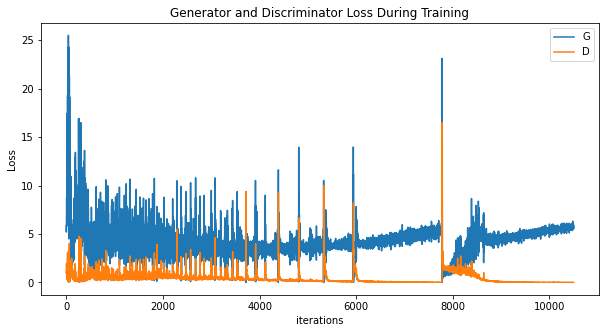

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(DEFAULT_GAN_OUTPUT + os.sep + 'GAN_loss_training.jpg')
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




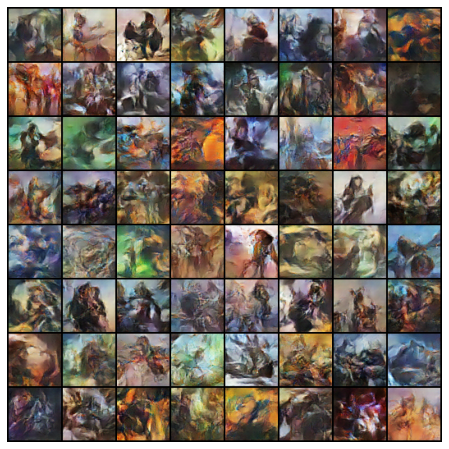

In [19]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
ani.save(DEFAULT_GAN_OUTPUT + os.sep + 'training.gif', writer='pillow', fps=1)

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




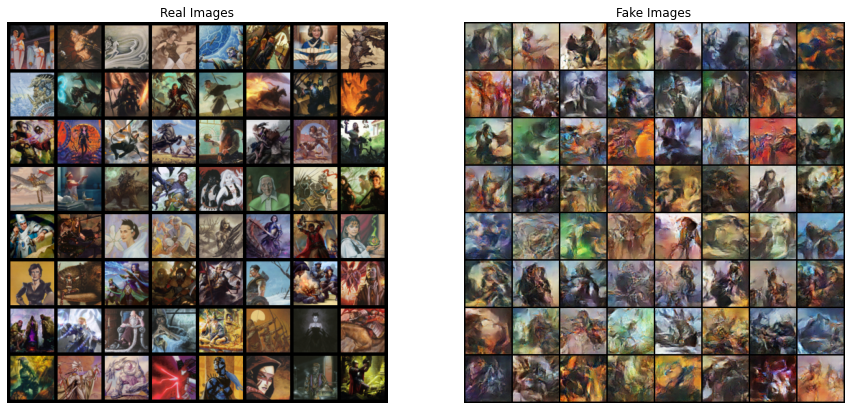

In [21]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

plt.savefig(DEFAULT_GAN_OUTPUT + os.sep + 'real_vs_fake.jpg')
plt.show()


torch.Size([557, 557, 3])
torch.Size([128, 3, 64, 64])
real_A.shape torch.Size([3, 64, 64])
real_B.shape torch.Size([64, 64, 3])


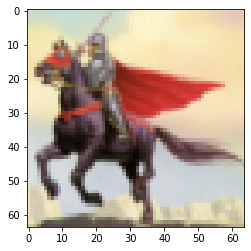

img_list[-1].shape torch.Size([3, 530, 530])
img_list_to_plot.shape torch.Size([530, 530, 3])


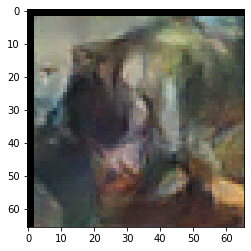

In [16]:
print(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)).shape)
print(real_batch[0].shape)
real_A = real_batch[0][0,:,:,:]
real_B = np.transpose(vutils.make_grid(real_batch[0].to(device)[5], padding=5, normalize=True).cpu(),(1,2,0))
print("real_A.shape", real_A.shape)
print("real_B.shape", real_B.shape)
plt.imshow(real_B)
plt.show()

print("img_list[-1].shape", img_list[-1].shape)
img_list_to_plot = np.transpose(img_list[-1],(1,2,0)) 
print("img_list_to_plot.shape", img_list_to_plot.shape)
plt.imshow(img_list_to_plot[:66,:66,:])
plt.show()

Where to Go Next
----------------

We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>`__


